# POLI/USP Trabalho de Conclusão de Curso
## Preparação dos dados da B3
Autor: Gabriel Benvegmi

Esse notebook faz a preparação dos dados dos documentos a partir dos textos que foram baixados pelo notebook `Webscraping dos dados da B3`, e que foram extraídos em documentos txt pelo script  `src/extract_pdf.py`.

In [ ]:
import os
import re
import requests
import sys
from io import StringIO

import gspread
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Recuperando os dados dos documentos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/Estudos/Poli/TCC/notebooks/"

In [ ]:
docs_cols = [
    "published_date",
    "published_title",
    "published_abstract",
    "published_subject",
    "url",
    "file_name",
    "pypdfium_extraction",
    "pdfminer_extraction"
]
docs_df = pd.read_parquet(f"{save_path}0_list_b3_pdf_comparison.parquet", engine="pyarrow")
docs_df = docs_df[docs_cols]

# Recuperando apenas aqueles relativos ao ano de 2023
docs_df = docs_df[docs_df["published_date"].dt.year == 2023]

In [ ]:
docs_df.sort_values("published_date", ascending=False)

,published_date,published_title,published_abstract,published_subject,url,file_name,pypdfium_extraction,pdfminer_extraction
0,2023-11-09,187-2023-PRE-Ofício Circular,"Informamos que, a partir de 13/11/2023, inclus...",Alteração na Regra de Cadastro Automático de V...,https://www.b3.com.br/data/files/73/E7/C5/27/2...,2023-11-09|187-2023-PRE-Ofício Circular.pdf,Este documento produz efeitos a partir da data...,9 de novembro de 2023 \n187/2023-PRE \n\nOFÍCI...
4,2023-11-09,186-2023-PRE-Ofício Circular,"Informamos que, a partir de 27/11/2023, serão ...",Novas Regras e Parâmetros para Procedimentos E...,https://www.b3.com.br/data/files/0F/44/94/03/7...,2023-11-09|186-2023-PRE-Ofício Circular.pdf,Este documento produz efeitos a partir da data...,9 de novembro de 2023 \n186/2023-PRE \n\nOFÍCI...
6,2023-11-09,109-2023-VNC-Comunicado Externo,"Informamos que, conforme divulgado no Comunica...",Sessão de Negociação Simulada – PUMA Trading S...,https://www.b3.com.br/data/files/81/40/5E/CF/2...,2023-11-09|109-2023-VNC-Comunicado Externo.pdf,Este documento produz efeitos a partir da data...,9 de novembro de 2023 \n109/2023-VNC \n\nCOMUN...
5,2023-11-09,108-2023-VNC-Comunicado Externo,Informamos que as especificações técnicas do D...,EntryPoint – Interface de envio de ordens: nov...,https://www.b3.com.br/data/files/60/F7/D0/49/E...,2023-11-09|108-2023-VNC-Comunicado Externo.pdf,Este documento produz efeitos a partir da data...,9 de novembro de 2023 \n108/2023-VNC \n\nCOMUN...
1,2023-11-09,107-2023-VNC-Comunicado Externo,"A B3 informa que, conforme Comunicado Externo ...",Lançamento das sessões de Renda Fixa Trademate,https://www.b3.com.br/data/files/78/67/00/8C/C...,2023-11-09|107-2023-VNC-Comunicado Externo.pdf,Este documento produz efeitos a partir da data...,9 de novembro de 2023 \n107/2023-VNC \n\nCOMUN...
...,...,...,...,...,...,...,...,...
417,2023-01-05,002-2023-VPC-Comunicado Externo,Informamos que estão previstas para 10/04/2023...,Plataforma NoMe – Balcão B3 – implementações r...,https://www.b3.com.br/data/files/29/D3/04/9A/A...,2023-01-05|002-2023-VPC-Comunicado Externo.pdf,Este documento produz efeitos a partir da data...,5 de janeiro de 2023 \n002/2023-VPC \n\nCOMUNI...
418,2023-01-05,003-2023-VPC-Ofício Circular,"Informamos que, a partir da divulgação deste O...",Alteração de cotas de Fundo de Investimento Im...,https://www.b3.com.br/data/files/D0/06/85/8D/1...,2023-01-05|003-2023-VPC-Ofício Circular.pdf,Este documento produz efeitos a partir da data...,5 de janeiro de 2023 \n003/2023-VPC \n\nOFÍCIO...
419,2023-01-03,001-2023-VPC-Comunicado Externo,Informamos que estão previstas para 13/02/2023...,Plataforma NoMe – Balcão B3 – implementações r...,https://www.b3.com.br/data/files/F6/A7/1E/13/8...,2023-01-03|001-2023-VPC-Comunicado Externo.pdf,Este documento produz efeitos a partir da data...,3 de janeiro de 2023 \n001/2023-VPC \n\nCOMUNI...
420,2023-01-03,001-2023-VPC-Ofício Circular,"A B3 informa que, devido ao evento corporativo...",Alteração dos Parâmetros de Atuação do Program...,https://www.b3.com.br/data/files/D8/12/FA/E7/C...,2023-01-03|001-2023-VPC-Ofício Circular.pdf,Este documento produz efeitos a partir da data...,3 de janeiro de 2023 \n001/2023-VPC \n\nOFÍCIO...


## Recuperando o conteúdo da Adobe Extract API
Aqui, para cada documento de referência recupera-se o conteúdo do arquivo processado a partir da API da Adobe. Usou-se como convenção a data de publicação mais o código dos documentos como uma chave de identificação dos registros.

In [ ]:
base_path = "/content/drive/MyDrive/Estudos/Poli/TCC/data/txt_2023"
def fetch_file_content(row):
  file_name = row["txt_file_name"]
  try:
    with open(os.path.join(base_path, file_name), "r") as f:
      content = f.read()
  except Exception as e:
    raise e

  return content

docs_df["txt_file_name"] = docs_df["file_name"].str.replace("\.pdf", ".txt", regex=True).str.strip()
docs_df["adobe_extraction"] = docs_df.apply(fetch_file_content, axis=1)

docs_df.head(10)

,published_date,published_title,published_abstract,published_subject,url,file_name,pypdfium_extraction,pdfminer_extraction,txt_file_name,adobe_extraction
0,2023-11-09,187-2023-PRE-Ofício Circular,"Informamos que, a partir de 13/11/2023, inclus...",Alteração na Regra de Cadastro Automático de V...,https://www.b3.com.br/data/files/73/E7/C5/27/2...,2023-11-09|187-2023-PRE-Ofício Circular.pdf,Este documento produz efeitos a partir da data...,9 de novembro de 2023 \n187/2023-PRE \n\nOFÍCI...,2023-11-09|187-2023-PRE-Ofício Circular.txt,"Informamos que, a partir de 13/11/2023, inclus..."
1,2023-11-09,107-2023-VNC-Comunicado Externo,"A B3 informa que, conforme Comunicado Externo ...",Lançamento das sessões de Renda Fixa Trademate,https://www.b3.com.br/data/files/78/67/00/8C/C...,2023-11-09|107-2023-VNC-Comunicado Externo.pdf,Este documento produz efeitos a partir da data...,9 de novembro de 2023 \n107/2023-VNC \n\nCOMUN...,2023-11-09|107-2023-VNC-Comunicado Externo.txt,"A B3 informa que, conforme Comunicado Externo ..."
2,2023-11-09,058-2023-VPC-Comunicado Externo,"Informamos que, em 27/10/2023, a Receita Feder...",Imposto de Renda da Pessoa Física (IRPF) – Cál...,https://www.b3.com.br/data/files/43/00/01/01/9...,2023-11-09|058-2023-VPC-Comunicado Externo.pdf,Este documento produz efeitos a partir da data...,9 de novembro de 2023 \n058/2023-VPC \n\nCOMUN...,2023-11-09|058-2023-VPC-Comunicado Externo.txt,"Informamos que, em 27/10/2023, a Receita Feder..."
3,2023-11-09,059-2023-VPC-Comunicado Externo,"A B3 informa que, os dados indicados neste Com...",Atualização cadastral de companhias emissoras ...,https://www.b3.com.br/data/files/31/60/A7/FF/A...,2023-11-09|059-2023-VPC-Comunicado Externo.pdf,Este documento produz efeitos a partir da data...,9 de novembro de 2023 \n059/2023-VPC \n\nCOMUN...,2023-11-09|059-2023-VPC-Comunicado Externo.txt,"A B3 informa que, no dia 13/11/2023, atualizar..."
4,2023-11-09,186-2023-PRE-Ofício Circular,"Informamos que, a partir de 27/11/2023, serão ...",Novas Regras e Parâmetros para Procedimentos E...,https://www.b3.com.br/data/files/0F/44/94/03/7...,2023-11-09|186-2023-PRE-Ofício Circular.pdf,Este documento produz efeitos a partir da data...,9 de novembro de 2023 \n186/2023-PRE \n\nOFÍCI...,2023-11-09|186-2023-PRE-Ofício Circular.txt,"Informamos que, a partir de 27/11/2023, serão ..."
5,2023-11-09,108-2023-VNC-Comunicado Externo,Informamos que as especificações técnicas do D...,EntryPoint – Interface de envio de ordens: nov...,https://www.b3.com.br/data/files/60/F7/D0/49/E...,2023-11-09|108-2023-VNC-Comunicado Externo.pdf,Este documento produz efeitos a partir da data...,9 de novembro de 2023 \n108/2023-VNC \n\nCOMUN...,2023-11-09|108-2023-VNC-Comunicado Externo.txt,Informamos que as especificações técnicas do D...
6,2023-11-09,109-2023-VNC-Comunicado Externo,"Informamos que, conforme divulgado no Comunica...",Sessão de Negociação Simulada – PUMA Trading S...,https://www.b3.com.br/data/files/81/40/5E/CF/2...,2023-11-09|109-2023-VNC-Comunicado Externo.pdf,Este documento produz efeitos a partir da data...,9 de novembro de 2023 \n109/2023-VNC \n\nCOMUN...,2023-11-09|109-2023-VNC-Comunicado Externo.txt,"Informamos que, conforme divulgado no Comunica..."
7,2023-11-07,185-2023-PRE-Ofício Circular,"A B3 informa que, a partir da data de publicaç...",Lançamento do Gateway Binário e atualização da...,https://www.b3.com.br/data/files/D7/C3/98/CC/2...,2023-11-07|185-2023-PRE-Ofício Circular.pdf,Este documento produz efeitos a partir da data...,7 de novembro de 2023 \n185/2023-PRE \n\nOFÍCI...,2023-11-07|185-2023-PRE-Ofício Circular.txt,"A B3 informa que, a partir da data de publicaç..."
8,2023-11-07,183-2023-PRE-Ofício Circular,A B3 informa os procedimentos de credenciament...,Processo de Credenciamento no Programa de Form...,https://www.b3.com.br/data/files/F5/63/F0/85/6...,2023-11-07|183-2023-PRE-Ofício Circular.pdf,Este documento produz efeitos a partir da data...,7 de novembro de 2023 \n183/2023-PRE \n\nOFÍC...,2

## Análise
Agora uma análise simples sobre o tamanhos dos documentos.

In [ ]:
docs_df["tokens_amount"] = docs_df["adobe_extraction"].str.split().str.len()

In [ ]:
quantiles = docs_df["tokens_amount"].quantile([0.25,0.5,0.75])
quantiles

# Algumas referências de investigações anteriores:
# pypdfium
# 0.25    185.25
# 0.50    278.00
# 0.75    584.50

# pdfminer
# 0.25    157.0
# 0.50    245.5
# 0.75    530.0

# Adobe - pre-remoção "Esclarecimentos" e tratamento de multiplos anexos
# 0.25    127.00
# 0.50    204.00
# 0.75    430.75

# Adobe - pos-remoção "Esclarecimentos" e tratamento de multiplos anexos
# 0.25    105.0
# 0.50    182.0
# 0.75    359.0

0.25    105.0
0.50    182.0
0.75    359.0
Name: tokens_amount, dtype: float64

In [ ]:
# Alguns documentos tiveram problemas em suas extrações, mesmo depois de inúmeras
# iterações no processamento dos arquivos extraídos pela API da Adobe
docs_df[docs_df["tokens_amount"] == 0]

,published_date,published_title,published_abstract,published_subject,url,file_name,pypdfium_extraction,pdfminer_extraction,txt_file_name,adobe_extraction,tokens_amount
73,2023-09-21,012-2023-VPC-Ofício Circular,"Informamos o lançamento, a partir de 21/09/202...",Lançamento do Índice DAP5 B3,https://www.b3.com.br/data/files/D8/35/E8/19/F...,2023-09-21|012-2023-VPC-Ofício Circular.pdf,Este documento produz efeitos a partir da data...,21 de setembro de 2023 \n012/2023-VPC \n\nOFÍC...,2023-09-21|012-2023-VPC-Ofício Circular.txt,,0
88,2023-09-12,080-2023-VNC-Comunicado Externo,"A B3, conforme disposto na Resolução CMN 1.660...",204º Leilão Especial do Fundo de Investimentos...,https://www.b3.com.br/data/files/3D/55/BD/5D/D...,2023-09-12|080-2023-VNC-Comunicado Externo.pdf,Este documento produz efeitos a partir da data...,12 de setembro de 2023 \n\n080/2023-VNC \n\nCO...,2023-09-12|080-2023-VNC-Comunicado Externo.txt,,0
92,2023-09-12,081-2023-VNC-Comunicado Externo,"A B3, conforme disposto na Resolução CMN 1.660...",293º Leilão Especial do Fundo de Investimentos...,https://www.b3.com.br/data/files/04/D6/66/EC/1...,2023-09-12|081-2023-VNC-Comunicado Externo.pdf,Este documento produz efeitos a partir da data...,12 de setembro de 2023 \n\n081/2023-VNC \n\nCO...,2023-09-12|081-2023-VNC-Comunicado Externo.txt,,0
166,2023-07-11,120-2023-PRE-Ofício Circular,"Informamos que, a partir de 01/08/2023, estará...",Novo Fluxo – Carta de Circularização,https://www.b3.com.br/data/files/97/64/AB/1E/2...,2023-07-11|120-2023-PRE-Ofício Circular.pdf,Este documento produz efeitos a partir da data...,11 de julho de 2023 \n120/2023-PRE \n\nOFÍCIO ...,2023-07-11|120-2023-PRE-Ofício Circular.txt,,0
186,2023-06-27,105-2023-PRE-Ofício Circular,"A B3 informa que, para melhorar e simplificar ...",Contratos Futuros de Índices com Liquidação Fi...,https://www.b3.com.br/data/files/DD/F6/42/87/1...,2023-06-27|105-2023-PRE-Ofício Circular.pdf,Este documento produz efeitos a partir da data...,27 de junho de 2023 \n105/2023-PRE \n\nOFÍCIO ...,2023-06-27|105-2023-PRE-Ofício Circular.txt,,0
331,2023-04-04,044-2023-PRE-Ofício Circular,A B3 informa o lançamento do módulo DATAWISE P...,Lançamento do DATAWISE Plus,https://www.b3.com.br/data/files/DD/D2/45/C4/6...,2023-04-04|044-2023-PRE-Ofício Circular.pdf,Este documento produz efeitos a partir da data...,04 de abril de 2023 \n044/2023-PRE \n\nOFÍCIO ...,2023-04-04|044-2023-PRE-Ofício Circular.txt,,0


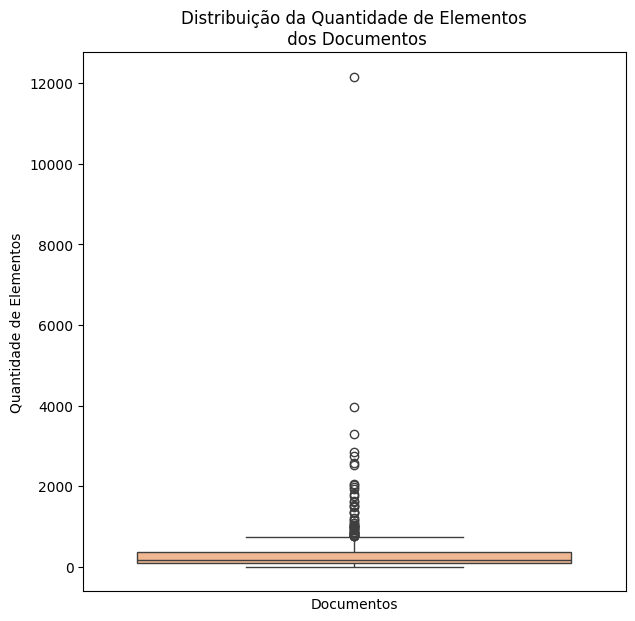

In [ ]:
plt.figure(figsize=(7, 7))
ax = sns.boxplot(data=docs_df[["tokens_amount"]], color="#ffb482")

plt.title('Distribuição da Quantidade de Elementos\n dos Documentos')
plt.xlabel('Documentos')
plt.ylabel('Quantidade de Elementos')

plt.xticks([])

plt.show()

In [ ]:
filtered_docs_df = docs_df[
    (docs_df["tokens_amount"] > quantiles[0.25]) &
    (docs_df["tokens_amount"] < quantiles[0.75])
]

In [ ]:
quantiles_after = filtered_docs_df["tokens_amount"].quantile([0.25,0.5,0.75])
quantiles_after

# Novamente, algumas referências de investigações anteriores:
# pypdfiym(?)
# 0.25    228.00
# 0.50    278.00
# 0.75    360.75

# pdfminer
# 0.25    198.5
# 0.50    249.0
# 0.75    322.5

# Adobe - pre-remoção "Esclarecimentos" e tratamento de multiplos anexos
# 0.25    166.0
# 0.50    204.0
# 0.75    268.0

# Adobe - pos-remoção "Esclarecimentos" e tratamento de multiplos anexos
# 0.25    139.0
# 0.50    182.0
# 0.75    231.0

0.25    139.0
0.50    182.0
0.75    231.0
Name: tokens_amount, dtype: float64

Abaixo encontram-se algumas estatísticas descritivas, tanto em formato de tabela como em gráficos.

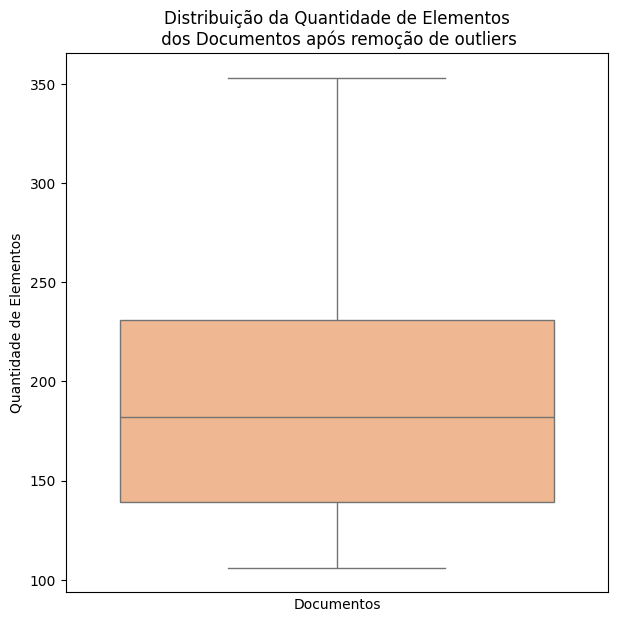

In [ ]:
plt.figure(figsize=(7, 7))
ax = sns.boxplot(filtered_docs_df["tokens_amount"], color="#ffb482")

plt.title('Distribuição da Quantidade de Elementos\n dos Documentos após remoção de outliers')
plt.xlabel('Documentos')
plt.ylabel('Quantidade de Elementos')

plt.xticks([])

plt.show()

In [ ]:
filtered_docs_df.describe()

,tokens_amount
count,208.000000
mean,191.899038
std,64.222322
min,106.000000
25%,139.000000
50%,182.000000
75%,231.000000
max,353.000000


In [ ]:
filtered_docs_df = filtered_docs_df[
    ['published_date', 'published_title', 'published_abstract', 'published_subject', 'url', 'file_name', 'adobe_extraction', 'tokens_amount']
]

In [ ]:
filtered_docs_df.index = filtered_docs_df["published_title"]
filtered_docs_df.drop(columns=["published_title"])
filtered_docs_df.head()

,published_date,published_title,published_abstract,published_subject,url,file_name,adobe_extraction,tokens_amount
published_title,,,,,,,,
187-2023-PRE-Ofício Circular,2023-11-09,187-2023-PRE-Ofício Circular,"Informamos que, a partir de 13/11/2023, inclus...",Alteração na Regra de Cadastro Automático de V...,https://www.b3.com.br/data/files/73/E7/C5/27/2...,2023-11-09|187-2023-PRE-Ofício Circular.pdf,"Informamos que, a partir de 13/11/2023, inclus...",122
107-2023-VNC-Comunicado Externo,2023-11-09,107-2023-VNC-Comunicado Externo,"A B3 informa que, conforme Comunicado Externo ...",Lançamento das sessões de Renda Fixa Trademate,https://www.b3.com.br/data/files/78/67/00/8C/C...,2023-11-09|107-2023-VNC-Comunicado Externo.pdf,"A B3 informa que, conforme Comunicado Externo ...",239
059-2023-VPC-Comunicado Externo,2023-11-09,059-2023-VPC-Comunicado Externo,"A B3 informa que, os dados indicados neste Com...",Atualização cadastral de companhias emissoras ...,https://www.b3.com.br/data/files/31/60/A7/FF/A...,2023-11-09|059-2023-VPC-Comunicado Externo.pdf,"A B3 informa que, no dia 13/11/2023, atualizar...",147
186-2023-PRE-Ofício Circular,2023-11-09,186-2023-PRE-Ofício Circular,"Informamos que, a partir de 27/11/2023, serão ...",Novas Regras e Parâmetros para Procedimentos E...,https://www.b3.com.br/data/files/0F/44/94/03/7...,2023-11-09|186-2023-PRE-Ofício Circular.pdf,"Informamos que, a partir de 27/11/2023, serão ...",353
184-2023-PRE-Ofício Circular,2023-11-07,184-2023-PRE-Ofício Circular,"Informamos que, em 21/11/2023, entrarão em vig...",Alterações no Regulamento da Câmara B3 e no Ma...,https://www.b3.com.br/data/files/49/37/82/51/C...,2023-11-07|184-2023-PRE-Ofício Circular.pdf,"Informamos que, em 21/11/2023, entrarão em vig...",196


## Separação das passagens
A fim de se criar as passagens de referência para que os avaliadores humanos possam atuar, as lógicas abaixo foram implementadas. Dessa forma, um dado documento foi separado em 3 passagens, todas contendo sentenças inteiras.

Casos em que eventualmente não se conseguiu fazer esse processo foram demarcados como problemáticos.

In [ ]:
def break_line_on_print(str_text, min_size=100, max_size=150):
  result_str = ""
  idx = 0

  for letter in str_text:
    if (idx >= min_size and idx <= max_size and letter == " "):
      letter  = "\n"
      idx = 0

    result_str += letter
    idx += 1

  return result_str

def calculate_left_distance(input_str, pre_position, ref_position):
  try:
    left_pos_idx = input_str[pre_position:ref_position].rindex(". ") + pre_position
    left_distance = ref_position - left_pos_idx
  except ValueError as e:
    left_distance = sys.maxsize
    left_pos_idx = pre_position

  return left_pos_idx, left_distance


def calculate_right_distance(input_str, ref_position, post_position):
  try:
    right_pos_idx = input_str[ref_position:post_position].index(". ") + ref_position
    right_distance = right_pos_idx - ref_position
  except ValueError as e:
    right_distance = sys.maxsize
    right_pos_idx = post_position

  return right_pos_idx, right_distance

In [ ]:
def generate_intervals(input_str, passages_amount=3):

  # Calcula o tamanho do texto
  input_str_len = len(input_str)
  # print(input_str_len)

  # Divide pela qtde de passagens (padrão é 3)
  passage_size = input_str_len // passages_amount # round(input_str_len // 5)

  # Localiza o índice de separação ideal para cada passagem
  positions = np.arange(0+passage_size, input_str_len, passage_size).tolist()
  positions.insert(0, 0)

  # Força o último intervalo a terminar no fim da string de entrada
  positions[-1] = input_str_len

  # Gera uma lista de listas com posições de índices pré-intervalo, índice de referência e pós-intervalo, conforme abaixo:
  # [[0, 485, 970], [485, 970, 1455], [970, 1455, 1940], [1455, 1940, 2428]]
  intervals = [[positions[i], positions[i+1], positions[i+2]] for i in range(len(positions)-2)]

  return intervals

In [ ]:
# Implementação alternativa da função acima. ATENÇÂO: foi esta a versão realmente
# utilizada
def _process_intervals(intervals, input_str_len, passage_size, threshold):
  final_list = []
  threshold_limit = round(passage_size * threshold)

  for interval_range in intervals:
    diff = interval_range[2] - interval_range[1]

    if diff == passage_size:
      final_list.append(interval_range)
    elif (diff <= threshold_limit) and (diff != 0):
      interval_range[-1] = input_str_len
      interval_range[-2] = input_str_len
      final_list.append(interval_range)
    elif (interval_range[1] != input_str_len) and (interval_range[2] == input_str_len):
      final_list.append(interval_range)
      break
    elif (interval_range[1] == input_str_len) and (interval_range[2] == input_str_len):
      final_list.append(interval_range)
      break
    else:
      # print(f"passing {interval_range}")
      continue

  return final_list

def generate_intervals(input_str, passages_amount=3, threshold=0.1):
  input_str_len = len(input_str)
  passage_size = input_str_len // passages_amount
  intervals = [
      [max(i, 0), min(i+passage_size, input_str_len), min(input_str_len, i+passage_size*2)]
      for i in range(0, input_str_len+1, passage_size)
  ]

  processed_intervals = _process_intervals(intervals, input_str_len, passage_size, threshold)

  return processed_intervals

In [ ]:
def build_df(row, i, passage, problematic, idx):
  return pd.DataFrame({
      "published_date": [row["published_date"]],
      "url": [row["url"]],
      "file_name": [row["file_name"]],
      "text_passage_idx": [i],
      "text_passage_content": [passage],
      "problematic": [problematic],
      "tokens_amount": [row["tokens_amount"]]
  }, index = [idx]
  )

In [ ]:
def _build_passages(passages_df, pre_position, split_idx):
  passage = input_str[pre_position:split_idx]

  tmp_df = build_df(row, i, passage, problematic, idx)
  passages_df = pd.concat([passages_df, tmp_df])
  print(f"{break_line_on_print(input_str[pre_position:split_idx])}")

  try:
    intervals[i+1] = [split_idx, intervals[i+1][1], intervals[i+1][2]]

  except IndexError:

    passage = input_str[split_idx:]
    final_df = build_df(row, i+1, passage, problematic, idx)
    passages_df = pd.concat([passages_df, final_df])

    if 1 in passages_df.loc[idx,"problematic"].tolist():
      passages_df.loc[idx,"problematic"] = 1 # Set all document rows as problematic

  return passages_df

Abaixo tem-se o loop principal de processamento:

In [ ]:
passages_df = pd.DataFrame(columns=["published_date", "url", "file_name", "text_passage_idx", "text_passage_content", "problematic", "tokens_amount"])
passages_df.index.name = "published_title"

passages_amount = 3

for idx, row in filtered_docs_df.iterrows():
  print(idx)
  input_str = row["adobe_extraction"]

  input_str_len = len(input_str)
  passage_size = input_str_len // passages_amount
  threshold = 0.15
  threshold_limit = round(passage_size * threshold)
  intervals = generate_intervals(input_str)
  problematic = 0

  for i in range(len(intervals)):
    pre_position, ref_position, post_position = intervals[i]

    left_pos_idx, left_distance = calculate_left_distance(input_str, pre_position, ref_position)
    right_pos_idx, right_distance = calculate_right_distance(input_str, ref_position, post_position)

    if right_pos_idx == input_str_len:
      print("case 5   -> intervals", intervals)
      split_idx = right_pos_idx + 1

      passages_df = _build_passages(passages_df, pre_position, split_idx)
      break
    elif left_distance < right_distance:
      print("case 1")
      split_idx = left_pos_idx + 1
    elif left_distance > right_distance:
      print("case 2")
      split_idx = right_pos_idx + 1
    elif (left_distance == right_distance) and (left_distance != sys.maxsize):
      print("case 3")
      split_idx = np.random.choice([left_pos_idx, right_pos_idx])
    elif ref_position + threshold_limit >= input_str_len:
      print("case 4")
      split_idx = input_str_len
    else: # Não temos uma serapação candidata para nenhum dos casos
      print("else")
      split_idx = ref_position
      problematic = 1

    print("split_idx     --->", split_idx)
    passages_df = _build_passages(passages_df, pre_position, split_idx)

Algumas análises rápidas a partir do resultado:

In [ ]:
len(passages_df[passages_df["problematic"] == 1].index.unique())

3

In [ ]:
passages_df.shape

(698, 7)

In [ ]:
filtered_docs_df.loc["187-2023-PRE-Ofício Circular", "adobe_extraction"]

'Informamos que, a partir de 13/11/2023, inclusive, será alterada a regra para cadastro automático de vencimentos do Contrato Futuro de Cupom de IPCA (DAP). A regra de cadastro automático de vencimentos foi revista, visando ampliar a abertura de novos vencimentos curtos de DAP, de 3 primeiros meses para 6, conforme tabela abaixo. Regra até 10/11/2023. Regra a partir de 13/11/2023. A regra vigente de cadastro automático e cadastro pré-aprovado de instrumentos para o DAP pode ser consultada em Regulação, Estrutura normativa, Regulamentos e manuais, Negociação, Acessar documentos, Critérios para Criação e Exclusão de Vencimentos Futuros e Séries de Opções. Ressaltamos que os demais termos do Contrato Futuro de Cupom de IPCA (DAP) permanecem inalterados. O único ajuste é referente ao cadastro automático.'

E finalmente uma análise visual de algumas das passagens geradas:

In [ ]:
for item in not_problematic_entries[:10]:
  item_passages = passages_df.loc[item, ["text_passage_idx", "text_passage_content"]]

  print(item)
  for _, passage in item_passages.iterrows():
    print(
        passage["text_passage_content"] == "",
        passage["text_passage_idx"],
        break_line_on_print(passage["text_passage_content"]),
        "\n",
        )
  print("\n", "_"*100,"\n")

187-2023-PRE-Ofício Circular
False 0 Informamos que, a partir de 13/11/2023, inclusive, será alterada a regra para cadastro automático de
vencimentos do Contrato Futuro de Cupom de IPCA (DAP). A regra de cadastro automático de vencimentos
foi revista, visando ampliar a abertura de novos vencimentos curtos de DAP, de 3 primeiros meses para
6, conforme tabela abaixo. 

False 1  Regra até 10/11/2023. Regra a partir de 13/11/2023. A regra vigente de cadastro automático e cadastro
pré-aprovado de instrumentos para o DAP pode ser consultada em Regulação, Estrutura normativa, Regulamentos
e manuais, Negociação, Acessar documentos, Critérios para Criação e Exclusão de Vencimentos Futuros
e Séries de Opções. 

False 2  Ressaltamos que os demais termos do Contrato Futuro de Cupom de IPCA (DAP) permanecem inalterados. O
único ajuste é referente ao cadastro automático. 

True 3  


 ____________________________________________________________________________________________________ 

107-2023-VNC-

Abaixo o salvamento do arquivo para geração da planilha dos avaliadores.

In [ ]:
passages_df.index.name = "published_title"

In [ ]:
passages_df = passages_df[passages_df["text_passage_content"] != ""]

In [ ]:
passages_df.loc[:, "text_passage_sentences_amount"] = passages_df["text_passage_content"].str.count("\.")
passages_df.loc[:, "summary"] = passages_df.apply(lambda row: row["text_passage_content"] if row["text_passage_sentences_amount"] == 1 else "", axis=1)
passages_df.drop(columns=["text_passage_sentences_amount"], inplace=True)

In [ ]:
passages_df.to_csv(f"{save_path}1_filtered_q1_q3_docs_passages_adobe_3_passages_v2_expanded.csv", index=True)

# Apêndices
Abaixo pode-se encontrar um método alternativo de processamento dos documentos que foi tentado inicialmente (em conjunto com o uso das biblitecas de extração de PDF em Python), mas descontinuado em favor da versão atual, que utilizou a API da Adobe para extração dos conteúdos PDF.


In [ ]:
# patterns_map = {
#   r"\r\n|\n|\r": " ",                                                                                  # Line breaks
#   r" (Este documento.*?Fax.*?PUBLIC INFORMATION )|(Este documento.*?Fax: \(11\) 2565-7737\s*?\d)": "", # Footers
#   r"\d{3}\/\d{4}-\w{3} ": "",                                                                          # Document IDs as 183-2023-PRE
#   r"[\u2022\u2023\u25E6\u2043\u2219] {0,1}": " ",                                                      # bullet points
#   r"\s{2,}": " ",                                                                                      # Multiple whitespaces
#   r"\d{1,2}.*?(EXTERNO|CIRCULAR).*?Ref\.: ": "",                                                       # Initial portion of the document
#   r"Anexo do OFÍCIO CIRCULAR.*": " ",                                                                  # Document attachments
#   r"BSM Supervisão de Mercados \+55 11 2565-6200.*?INFORMATION.*?\d": " ",                             # BSM Footers
#   r"\d{1,}\/\d{4}-BSM": " ",                                                                           # BSM Document IDs
#   r"\d Disponível.*:Documento assinado.*": " ",                                                        # BSM signatures
# }

# docs_df["cleaned_extraction"] = docs_df["pdfminer_extraction"]

# for pattern, replace_pattern in patterns_map.items():
#   docs_df["cleaned_extraction"] = (
#       docs_df["cleaned_extraction"]
#       .str.replace(pattern, replace_pattern, regex=True)
#   )

# docs_df["cleaned_extraction"] = docs_df["cleaned_extraction"].str.strip()

# docs_df.loc[:,"cleaned_extraction"] = (
#     docs_df.loc[:, "cleaned_extraction"].apply(lambda row: ''.join(c for c in row if c.isprintable()))
# )

# docs_df.index = docs_df["published_title"]
# docs_df.drop(columns="published_title", inplace=True)
# docs_df.head()

In [ ]:
# Remove reference from the beginning
# docs_df["skip_length"] = docs_df.apply(lambda row: len(row["published_subject"]) + 1, axis=1)
# docs_df["cleaned_extraction"] = docs_df.apply(lambda row: row["cleaned_extraction"][row["skip_length"]:], axis=1)

# docs_df.drop(columns=["skip_length"], inplace=True)
# docs_df.head()

In [ ]:
# Remove signature from the final part of the document
# docs_df["limit_length"] = docs_df.apply(lambda row: row["cleaned_extraction"].rindex(".") + 1, axis=1)
# docs_df["cleaned_extraction"] = docs_df.apply(lambda row: row["cleaned_extraction"][:row["limit_length"]], axis=1)

# docs_df.drop(columns=["limit_length"], inplace=True)
# docs_df.head()